In [ ]:
#using Revise

In [2]:
using Knet

In [2]:
#pkg"add Knet#master"

In [3]:
#using ImageView;

In [4]:
include("../helper.jl")
include("accuracy.jl")
include("loss.jl")
include("mpii.batcher.jl")
include("../models.jl")
include("../training.jl")
include("../plots.jl")
include("../modular.resnet.jl")

generate_headless_resnet50_from_weights (generic function with 1 method)

In [652]:
dtrn_2k, dval_2k, data_items = get_mpii_batches_and_data_items(8; should_shuffle=true)


LoadError: InterruptException:

In [683]:
dtrn_2k.shuffle = false
dtrn_first_two_batch = collect(take(dtrn_2k, 2))
dtrn_x1_2k, dtrn_y1_2k = first(dtrn_2k)
dval_x1_2k, dval_y1_2k = first(dval_2k)
dtrn_2k.shuffle = true

true

In [ ]:
# Loading Previous Batches
loaded_batches = Knet.load("20-12-2020-24kimage-batches.jld2", "24k-image-batches");
dtrn, dval = loaded_batches
dtrn_x1, dtrn_y1 = first(dtrn)
dval_x1, dval_y1 = first(dval)

In [736]:
val_data_items = data_items[end - validation_image_count + 1:end];
trn_data_items = data_items[begin: end - validation_image_count];

In [754]:
# TODO: check resnet implementation for its regularizations
should_use_resnet50 = true
modular_resnet = get_modular_resnet(should_use_resnet50);

In [755]:
resnet_with_deconv = Chain(modular_resnet.layers...,  
     Deconv(4, 4, global_num_joints, 2048; padding=1, stride=2, tag="part_detect_deconv"); 
    loss=sigmoid_cross_entropy_loss,
    deeperCutOption=DeeperCutOption(true));

In [ ]:
# Experimental

In [756]:
original_x = Knet.atype()(reshape(dtrn_2k.x, dtrn_2k.xsize));

In [757]:
# TODO: This can be used for visualization purposes 
arrange_img_damacfix = convert(Array{FixedPointNumbers.Normed{UInt8,8},3}, channelview(loaded_img));
converted_img = convert(Array{Float32}, arrange_img_damacfix);
img_v = @view converted_img[:, 38:75 , 112:177] # blue;
fill!(img_v, 0) # b;

In [758]:
#Knet.save("20-12-2020-24kimage-batches.jld2", "24k-image-batches", (dtrn, dval))

In [759]:
#size(resnet_with_deconv(dtrn_x1))

In [760]:
modelized_naive_pck_sigm(resnet_with_deconv, dval_2k)

0.020089285714285716

In [761]:
test_pck_image_order = 8

8

In [762]:
first_validation_image = original_x[:, : , :, test_pck_image_order:test_pck_image_order];

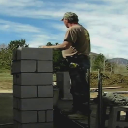

In [763]:
first_validation_image_3dim = Array(original_x[:, : , :, test_pck_image_order]);
perm = permutedims(first_validation_image_3dim, [3, 1, 2])
#dval_y1_2k
colorview(RGB, perm)

In [764]:
first_val_image_gold = dtrn_y1_2k[:, :,1:14, test_pck_image_order:test_pck_image_order];

In [779]:
first_val_image_output = resnet_with_deconv(first_validation_image)
#first_val_image_output_head = Array(first_val_image_output[:, :, :, 1:1]);

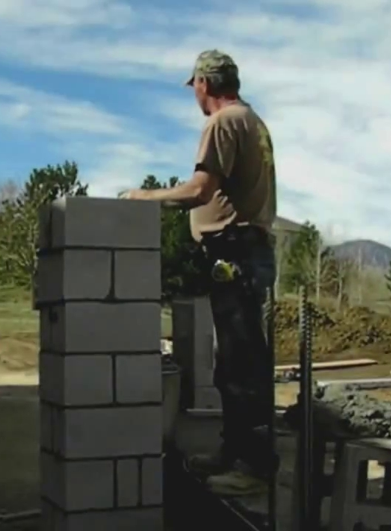

In [766]:
first_data_item = trn_data_items[test_pck_image_order];
load(first_data_item.path)

In [780]:
naive_pck(Array(first_val_image_output), Array(first_val_image_gold))

28.571428571428573

In [781]:
original_pckh(Array(first_val_image_output), [first_data_item])

57.142857142857146

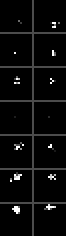

In [782]:
draw_score_maps(Array(first_val_image_output), 1);

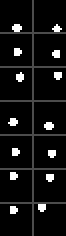

In [783]:
gold_img_outputs = draw_score_maps(Array(first_val_image_gold), 1);

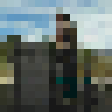

In [790]:
show_scmap_on_image(first_validation_image_3dim, 
    Array(first_val_image_output)[:, :, 6, 1]);

In [ ]:
# experimental end

In [772]:
modelized_PCKh_sigm(resnet_with_deconv, dtrn_2k, trn_data_items)

0.030691964285714284

In [777]:
model_end_results(resnet_with_deconv, dtrn_2k, dval_2k; 
    train_data_items=trn_data_items,
    validation_data_items=val_data_items)

train_acc_PCKh: 0.7739955357142857
train_loss: 0.08688605
train_acc: 0.8337053571428571
validation_PCKh: 0.36830357142857145
validation_loss: 0.16917644
validation_acc: 0.37276785714285715


In [ ]:
resnet_with_deconv_conv3_disabled = Chain(modular_resnet.layers...,  
     Deconv(4, 4, 14, 2048; padding=1, stride=2, tag="part_detect_deconv"); 
    loss=sigmoid_cross_entropy_loss,
    deeperCutOption=DeeperCutOption(false));

model_end_results(resnet_with_deconv_conv3_disabled, dtrn_2k, dval_2k)

# [(0.005, 1), (0.02, 20), (0.002, 15), (0.001, 15)]
resnetnet_results = trainresults(
    "resnet_with_deconv.jld2",
    resnet_with_deconv_conv3_disabled,
    dtrn_2k, dval_2k,
    [(0.02, 5)]; 
    accuracy_func=modelized_naive_pck_sigm,
    error_func=nothing);

In [3]:
CUDA.reclaim()
CUDA.memory_status() 
GC.gc(true)

LoadError: UndefVarError: CUDA not defined

In [775]:
resnetnet_results = trainresults("resnet_with_deconv.jld2",
    resnet_with_deconv,
    dtrn_2k,
    dval_2k, [(0.05, 40)]; 
    accuracy_func=modelized_naive_pck_sigm,
    error_func=nothing,
    secondary_accuracy_func=modelized_PCKh_sigm,
        data_items_trn=trn_data_items,
        data_items_val=val_data_items
    );

┣████████████████████┫ [100.00%, 640/640, 01:29/01:29, 7.15i/s]  


In [ ]:
#Knet.save("20-+5ep-12-2020-24kimage-resnet-50.jld2", "resnet_with_deconv", resnet_with_deconv)

In [ ]:
#resnet_with_deconv = Knet.load("20-+5ep-12-2020-24kimage-resnet-50.jld2", "resnet_with_deconv");

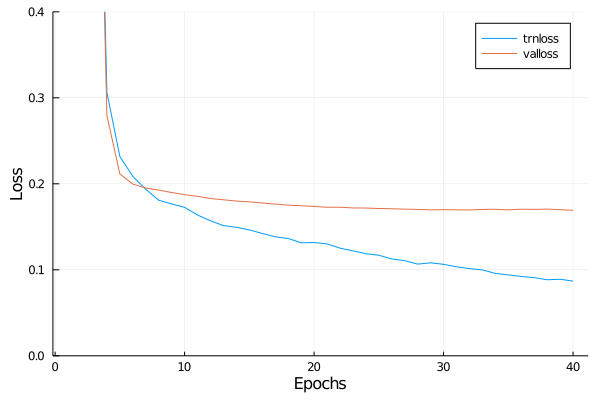

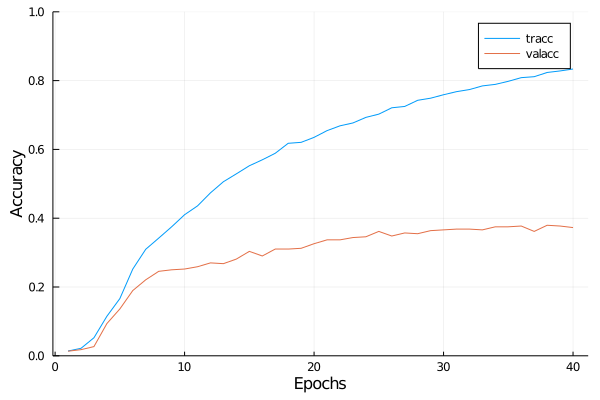

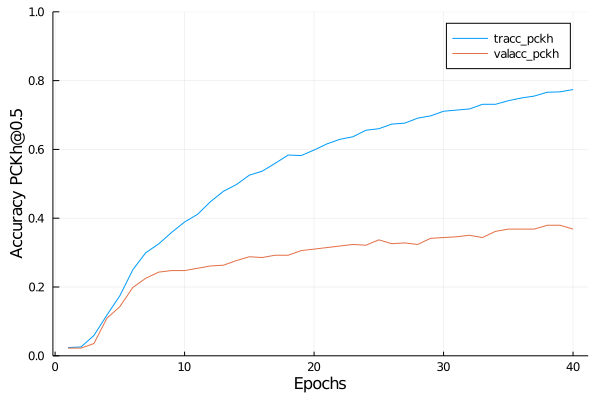

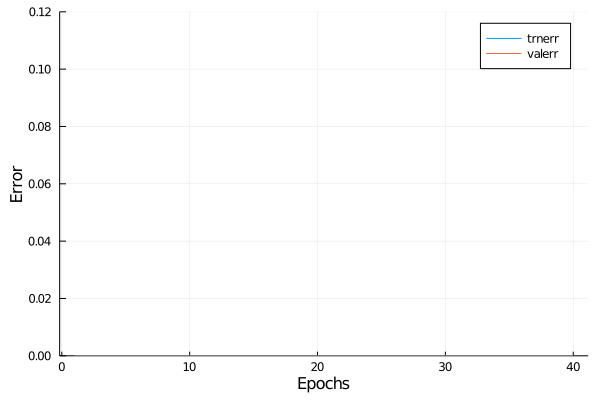

In [776]:
draw_plots(resnetnet_results)

In [ ]:
sigmoided_output = Array(sigm.(resnet_with_deconv(dtrn_x1)));

In [ ]:
sigmoided_output = Array(sigm.(loadedResNet(dtrn_x1)));

In [ ]:
sigmoided_output[ sigmoided_output .< output_consider_threshold] .= 0  ;

In [ ]:
test_image_order = 7;

In [ ]:
gt_joint_images = draw_score_maps(Array(dtrn_y1), test_image_order);

In [ ]:
pred_joint_images = draw_score_maps(sigmoided_output, test_image_order);

In [ ]:
pred_joint_images[14]

In [ ]:
gt_joint_images[14]

In [ ]:
images = []
for (i, joint_sc) in enumerate(gt_joint_images)
img = show_scmap_on_image(test_image, joint_sc;
        fill_value=1, 
        should_use_scmap_size=true,
    display_name=i)
    push!(images, img)
end

In [ ]:
mosaicify(images; ncol=3)

In [ ]:
show_scmap_on_image(test_image, pred_joint_images[13]; fill_value=1);

In [ ]:
should_use_output_sized = false
test_image = Array(dtrn_x1_2k)[:, :, :, test_image_order];
output_sized_test_image = imresize(test_image, 32, 32);
perm = permutedims( should_use_output_sized ? output_sized_test_image : test_image, [3, 1, 2])
colored = colorview(RGB, perm);
fetch(display(colored));
#colorview(RGB, rand(3,256,256))

In [ ]:
# Experimental Section

In [ ]:
first(dtrn)[1] |> size

In [ ]:
first(dtrn)[2] |> size

In [ ]:
#julia> w0 = KnetArray(randn(Float32, 5, 5, 1, 20));

#julia> x0 = KnetArray(rand(Float32, 24, 24, 20, 100));

#julia> size(deconv4(w0,x0)) # this output does not make it sense, it should give what I want
#(28, 28, 20, 100)
#

w0 = KnetArray(randn(Float32, 5, 5, 1, 20));
 x0 = KnetArray(rand(Float32, 4, 4, 2048, 32));

 # this output does not make it sense, it should give what I want
#(28, 28, 20, 100)

In [ ]:
dec_layer = Deconv(4, 4, 14, 2048; padding=1, stride=2, atype=Knet.atype())

In [ ]:
mock = randn(Float32, 16,16, 2048, 32);
mock = convert(Knet.atype(), mock);

In [ ]:
size(dec_layer(  mock ))

In [ ]:
size(deconv4(w0,x0))

In [ ]:
tc = Conv2(3, 3, 3, 3)

In [ ]:
fb = first(dtrn)[1];

In [ ]:
res_tc = tc2(fb) |> tc;

In [ ]:
mid = res_tc |> tc2

In [ ]:
w1 = KnetArray(randn(Float32, 3,3, 1, 3));

In [ ]:
#deconv4(w1, mid)
size(deconv4(w1, mid; padding=1))

In [ ]:
tc2 = ResLayerConv(3, 3, 3, 3; stride=2, padding=1)

In [ ]:
res_tc2 = res_tc |> tc2;

In [ ]:
size(res_tc)

In [ ]:
tc2(fb) |> tc2 |> tc2;